In [68]:
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

import sys

import fastparquet
import snappy

In [69]:
def showall(df):
    #shows entire dataframe
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)

In [70]:
alldays_timestamped = pd.read_parquet('alldays_timestamped.parquet')

/Users/edasmalchi/anaconda3/envs/ox/lib/python3.7/site-packages/fastparquet/core.py:278: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


In [4]:
def plot_oneday(oneday_df, palette):
    #drop location from multiindex
    dropped = oneday_df.droplevel('Vehicle_Location')
    #remove locations besides spc 1-3, bike lane
    dropped = dropped[~dropped['Vehicle Location'].isin(['SB travel lane', 
                                                        'NB right turn pocket', 'Both/Middle of Space 1 & 2'])]
    #order locations
    dropped.sort_values(by=['Vehicle Location'], inplace=True)
    #create time column from index for x-axis, assign enforcement start time
    dropped['time'] = dropped.index
    enf_start = dropped.index[0].to_pydatetime().replace(hour=18, minute=0)
    #time range to display
    times = [min(dropped['time']), max(dropped['time'])]
    fig,ax = plt.subplots()
    #plot using Seaborn strip plot, set x-axis range, add line at enforcement start time, format x-axis...
    ax = sns.stripplot(x="time", y="Vehicle Location", hue='Violator', palette=palette, data=dropped, size = 2, jitter=False)
    ax.set_xlim(times)
    ax.axvline(enf_start, label='Loading Zone Start', c='r')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title(oneday_df['Begin Date'][0])
    fig.autofmt_xdate()
    plt.show()

In [5]:
def plot_everything(allday_df):
    unique = allday_df['Violator'].unique()
    colors = ['green', 'tangerine', 'scarlet']
    palette = dict(zip(unique, sns.xkcd_palette(colors)))
    
    to_df = []
    for date in allday_df['Begin Date'].unique():
        oneday = allday_df[allday_df['Begin Date'] == date]
        #print(date)
        plot_oneday(oneday, palette)
        day_block_stats = blocking_stats(oneday)
        to_df += [day_block_stats]
        print(day_block_stats)
    return to_df

In [21]:
alldays_timestamped.sort_index(level='Timestamp', inplace=True)

In [22]:
oneday = alldays_timestamped.loc['2019-09-07 18:00:00':'2019-09-07 22:30:00']

In [45]:
def count_adv(df):
    #display(df)
    index = list(df['Violator'].unique()) + ['Both Violator'] + ['No Violator']
    series = pd.Series(data = 0, index = index, dtype=np.int64)
    for timestamp, newdf in df.groupby(level=0):
        one = pd.Series(data = 0, index = index, dtype=np.int64)
        one = one.add(newdf['Violator'].value_counts()).fillna(value=0)

        if 'Violator' in one.index and one['Violator'] == 2:
            one['Both Violator'] = 1
            one['Violator'] = 1
        if 'Violator' not in one.index:
            one['No Violator'] = 1
        
        series = series.add(one)
    if 'Likely Non-Violator' in series.index:
        series = series.drop(labels='Likely Non-Violator')
    return series

In [73]:
blocking_stats(oneday)

['09/07/2019', Bike Lane Blocking    5813.0
 Both Violator         2019.0
 No Violator              0.0
 Violator              4392.0
 dtype: float64, Bike Lane Blocking     5728.0
 Both Violator          4683.0
 No Violator               0.0
 Violator              12324.0
 dtype: float64]

In [74]:
def bigdf_at_times(littledf, bigdf):
    times = littledf.index
    bigdf = bigdf.loc[bigdf.index.isin(times)]
    bigdf.sort_index(inplace=True)
    return bigdf

In [67]:
def blocking_stats(bigdf, subset=None):
    bigdf = bigdf.droplevel('Vehicle_Location')
    df = bigdf.copy()
    
    if subset:
        df = subset
        
    #only look at blocking during loading zone time
    #df = df.droplevel('Vehicle_Location')
    df = df[df.index.hour >= 18]
    #generate df, stats for lane blocked-->violator present relationships
    blocked = df[df['Vehicle Location'] == 'SB bike lane']
    seconds_blocked = blocked.shape[0]
    
    blocked_counts = count_adv(bigdf_at_times(blocked, bigdf))
    ##
    #print(blocked_counts)
    ##
    #generate df, stats for violator present-->lane blocked relationships
    df_viol = df[df['Violator'] == 'Violator']
    viol_counts = count_adv(bigdf_at_times(df_viol, bigdf))
    ##
    #print(viol_counts)
    ##
    #return

    date = df['Begin Date'][0]
    try:
        return [date, blocked_counts, viol_counts]
    except:
        return 'blocking stats failed'

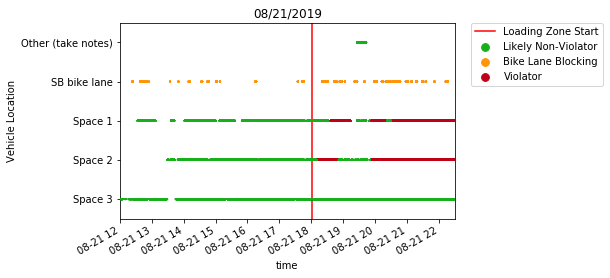

{'date': '08/21/2019', 'seconds_blocked': 3267, 'seconds_any_violator': 3055, 'blocking_any_violator_percentage': 0.9351086623813897, 'seconds_both_violator': 2058, 'blocking_both_violator_percentage': 0.6299357208448118}


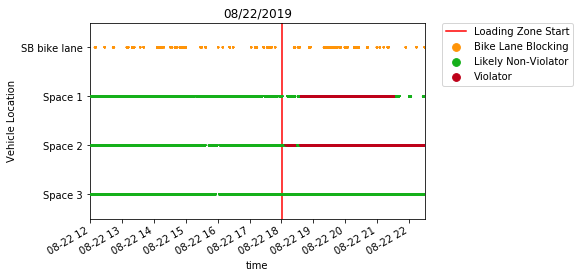

{'date': '08/22/2019', 'seconds_blocked': 3479, 'seconds_any_violator': 2881, 'blocking_any_violator_percentage': 0.8281115263006611, 'seconds_both_violator': 2677, 'blocking_both_violator_percentage': 0.7694739867778098}


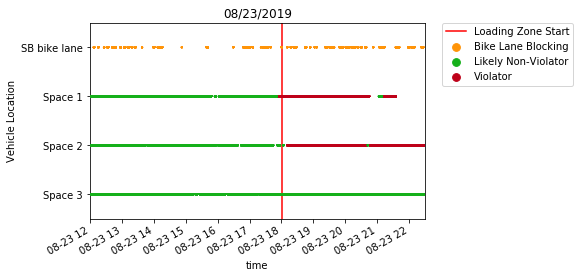

{'date': '08/23/2019', 'seconds_blocked': 3594, 'seconds_any_violator': 3427, 'blocking_any_violator_percentage': 0.9535336672231497, 'seconds_both_violator': 2363, 'blocking_both_violator_percentage': 0.6574846967167501}


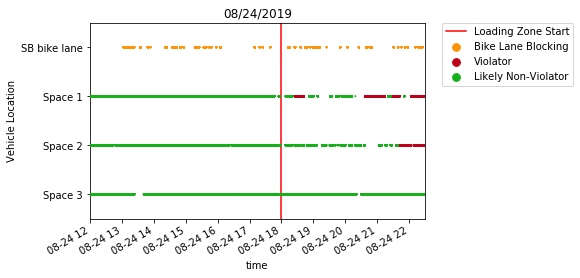

{'date': '08/24/2019', 'seconds_blocked': 1692, 'seconds_any_violator': 509, 'blocking_any_violator_percentage': 0.3008274231678487, 'seconds_both_violator': 97, 'blocking_both_violator_percentage': 0.057328605200945626}


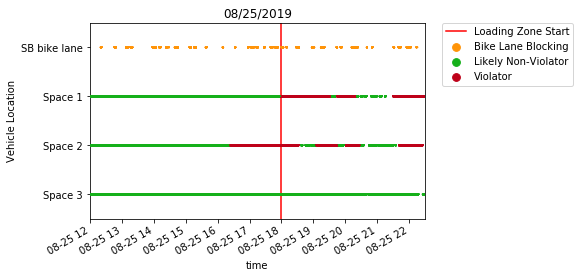

{'date': '08/25/2019', 'seconds_blocked': 2580, 'seconds_any_violator': 2021, 'blocking_any_violator_percentage': 0.7833333333333333, 'seconds_both_violator': 1528, 'blocking_both_violator_percentage': 0.5922480620155038}


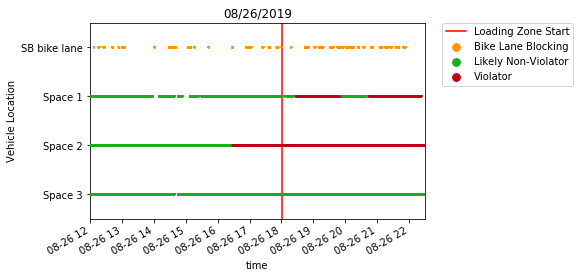

{'date': '08/26/2019', 'seconds_blocked': 3466, 'seconds_any_violator': 3281, 'blocking_any_violator_percentage': 0.9466243508366994, 'seconds_both_violator': 2268, 'blocking_both_violator_percentage': 0.6543566070398154}


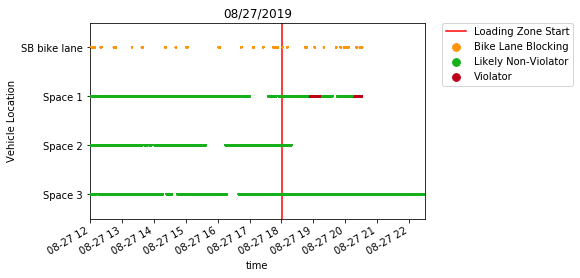

{'date': '08/27/2019', 'seconds_blocked': 726, 'seconds_any_violator': 316, 'blocking_any_violator_percentage': 0.43526170798898073, 'seconds_both_violator': 0, 'blocking_both_violator_percentage': 0.0}


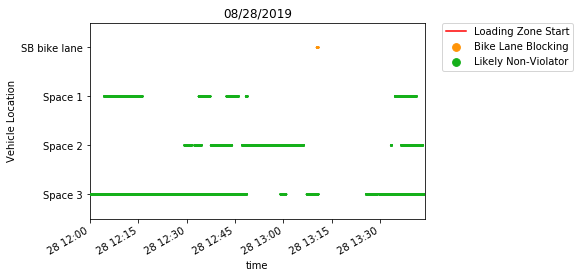

blocking stats failed


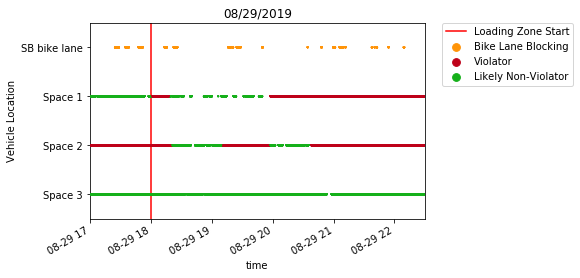

{'date': '08/29/2019', 'seconds_blocked': 1666, 'seconds_any_violator': 1228, 'blocking_any_violator_percentage': 0.737094837935174, 'seconds_both_violator': 715, 'blocking_both_violator_percentage': 0.429171668667467}


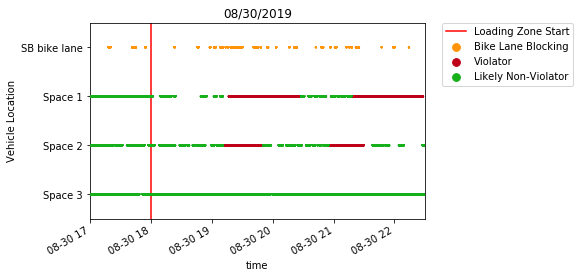

{'date': '08/30/2019', 'seconds_blocked': 2473, 'seconds_any_violator': 1644, 'blocking_any_violator_percentage': 0.6647796198948646, 'seconds_both_violator': 1063, 'blocking_both_violator_percentage': 0.4298422968054994}


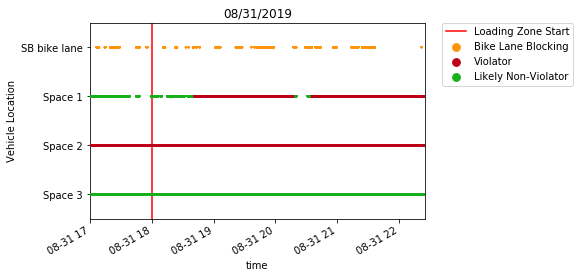

{'date': '08/31/2019', 'seconds_blocked': 5061, 'seconds_any_violator': 3998, 'blocking_any_violator_percentage': 0.7899624580122505, 'seconds_both_violator': 3225, 'blocking_both_violator_percentage': 0.6372258446947243}


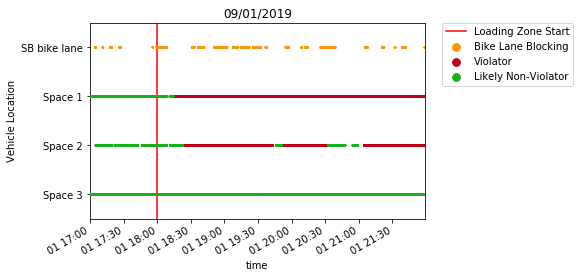

{'date': '09/01/2019', 'seconds_blocked': 4033, 'seconds_any_violator': 3156, 'blocking_any_violator_percentage': 0.7825440119018101, 'seconds_both_violator': 2956, 'blocking_both_violator_percentage': 0.7329531366228614}


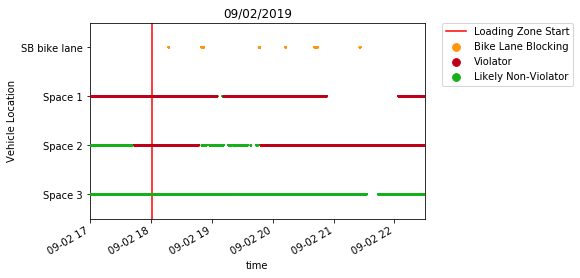

{'date': '09/02/2019', 'seconds_blocked': 419, 'seconds_any_violator': 419, 'blocking_any_violator_percentage': 1.0, 'seconds_both_violator': 253, 'blocking_both_violator_percentage': 0.60381861575179}


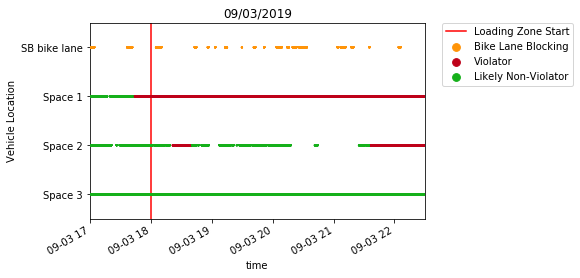

{'date': '09/03/2019', 'seconds_blocked': 2652, 'seconds_any_violator': 2423, 'blocking_any_violator_percentage': 0.9136500754147813, 'seconds_both_violator': 123, 'blocking_both_violator_percentage': 0.04638009049773756}


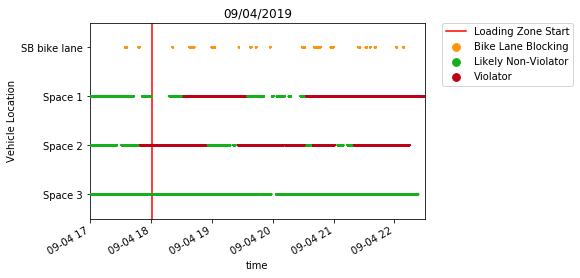

{'date': '09/04/2019', 'seconds_blocked': 1488, 'seconds_any_violator': 1374, 'blocking_any_violator_percentage': 0.9233870967741935, 'seconds_both_violator': 979, 'blocking_both_violator_percentage': 0.6579301075268817}


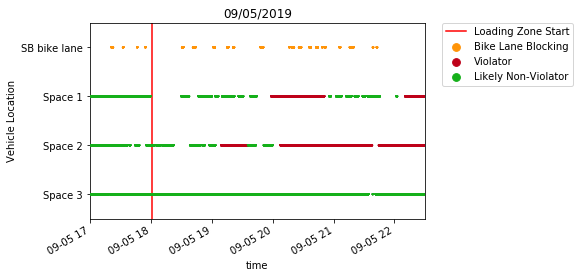

{'date': '09/05/2019', 'seconds_blocked': 1727, 'seconds_any_violator': 1035, 'blocking_any_violator_percentage': 0.5993051534452808, 'seconds_both_violator': 513, 'blocking_both_violator_percentage': 0.29704690214244356}


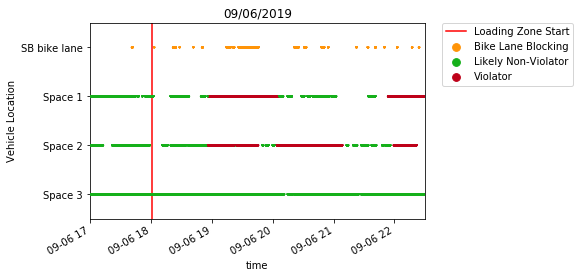

{'date': '09/06/2019', 'seconds_blocked': 2881, 'seconds_any_violator': 2157, 'blocking_any_violator_percentage': 0.7486983686220062, 'seconds_both_violator': 1501, 'blocking_both_violator_percentage': 0.5209996528982992}


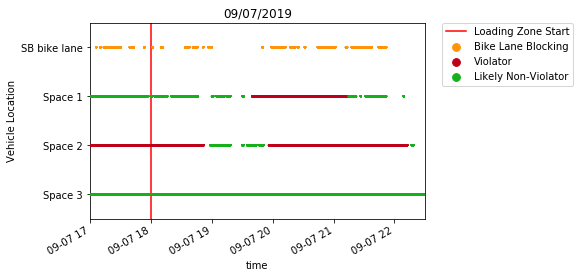

{'date': '09/07/2019', 'seconds_blocked': 5813, 'seconds_any_violator': 4392, 'blocking_any_violator_percentage': 0.7555479098572165, 'seconds_both_violator': 2019, 'blocking_both_violator_percentage': 0.34732496129365215}


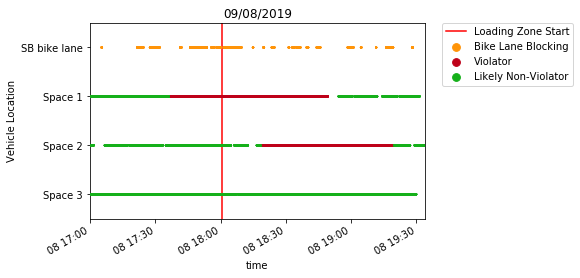

{'date': '09/08/2019', 'seconds_blocked': 1538, 'seconds_any_violator': 1412, 'blocking_any_violator_percentage': 0.918075422626788, 'seconds_both_violator': 468, 'blocking_both_violator_percentage': 0.30429128738621586}


In [56]:
to_df = plot_everything(alldays_timestamped)

In [11]:
df = pd.DataFrame()
for one_dict in to_df:
    #print(one_dict)
    try:
        #print(pd.DataFrame(one_dict, index=[0]))
        df = df.append(pd.DataFrame(one_dict, index=[0]))
    except:
        continue
df = df.set_index('date')

In [12]:
df

,seconds_blocked,seconds_any_violator,blocking_any_violator_percentage,seconds_both_violator,blocking_both_violator_percentage
date,,,,,
08/21/2019,3267,3055,0.935109,2058,0.629936
08/22/2019,3479,2881,0.828112,2677,0.769474
08/23/2019,3594,3427,0.953534,2363,0.657485
08/24/2019,1692,509,0.300827,97,0.057329
08/25/2019,2580,2021,0.783333,1528,0.592248
08/26/2019,3466,3281,0.946624,2268,0.654357
08/27/2019,726,316,0.435262,0,0.000000
08/29/2019,1666,1228,0.737095,715,0.429172
08/30/2019,2473,1644,0.664780,1063,0.429842


## Moving Forwards
* Scatter/fit line of seconds blocked+seconds any violator?
* Ask Juan about data formatting/outputs